In [13]:
###########################################################################################################################
## The work in this notebook has been conducted in collaboration with Marijn Visser from the Vrije Univeriteit Amsterdam ##
###########################################################################################################################

import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import loompy
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats.multitest import multipletests

from fetalxbrainxmultiomics.deepNeuron.model import ConvolutionalClassificationModel
from fetalxbrainxmultiomics.deepNeuron.utils import *
from captum.attr import DeepLiftShap
from deeplift.dinuc_shuffle import dinuc_shuffle
from deeplift.visualization import viz_sequence

from pybedtools import BedTool

In [6]:
def parse_merged_ldsc_outputs(filename, correction='Stringent', alpha=0.05):
    df = pd.read_csv(filename, sep=',')
    ## Stringent will correct for number of tests performed of phenotypes AND cell types
    if correction == 'Stringent':
        df = df.sort_values('Coefficient_P_value', ascending=True)
        
        #FDR
        df = df.reset_index()
        ranks2 = [i for i in range(1,df.shape[0]+1)]
        df['rank2']=ranks2
        i = range(1,136)
        df['FDR_thresh'] = df['rank2']/df.shape[0]
        df['FDR_thresh'] = df['FDR_thresh'] * alpha
        
        #Bonferoni
        bonf_cor = alpha /float(135*len(set(df['Phenotype'])))
        
        bonfs = []
        for i in range(len(df['Coefficient_P_value'])):
            p = float(df['Coefficient_P_value'][i])
            if p <= bonf_cor:
                bonfs.append(1)
            elif p <= float(df['FDR_thresh'][i]):
                bonfs.append(0.75)
            elif p <= 0.05:
                bonfs.append(0.1)
            else:
                bonfs.append(0)
        df.drop('index', inplace=True, axis=1)
        if 'level_0' in df.columns:
            df.drop('level_0', inplace=True, axis=1)
    ## Non-stringent will correct for number of tests performed of cell types
    else:
        #FDR
        i = range(1,136)
        df['rank'] = df.index.map(dict(zip(df.index, cycle(i))))
        df['FDR_thresh'] = df['rank']/135
        df['FDR_thresh'] = df['FDR_thresh'] * alpha
        
        #Bonferoni
        bonf_cor = alpha /float(135)
        bonfs = []
        for i in range(len(df['Coefficient_P_value'])):
            p = float(df['Coefficient_P_value'][i])
            if p <= bonf_cor:
                bonfs.append(1)
            elif p <= float(df['FDR_thresh'][i]):
                bonfs.append(0.75)
            elif p <= 0.05:
                bonfs.append(0.1)
            else:
                bonfs.append(0)
    df['bonf'] = bonfs
    df['log_P'] = np.log10(df['Coefficient_P_value']) *-1
    df=df.reset_index()
    return df
    
def rename_phenos(df): 
    new_phenos = []
    for pheno in df['Phenotype']:
        if '_' in str(pheno):
            pheno = pheno.split('_')[0]
        new_phenos.append(pheno)
    df['Phenotype'] =new_phenos
    df= df.dropna()
    df = df[df["Phenotype"] != 'age']
    return df 

def reorder_ukb(df, class_dict, phenos, domains):
    ylabels = []
    xlabels = []
    new_order = [x for (y,x) in sorted(zip(Y, X), key=lambda pair: pair[0])] 
    class_labels_sorted = [y for (y,x) in sorted(zip(Y,X), key=lambda pair: pair[0])]
    
    #shift position of control phenotype
    if 'random' in new_order:
        new_order = ['random'] + [x for x in new_order if not x == 'random']
        class_labels_sorted = ['Control'] + [x for x in class_labels_sorted if not x == 'Random']
        
    vertical_demarkations = []
    labelx = class_labels_sorted[0]
    ylabels.append(labelx)
    for i in range(len(class_labels_sorted)):
        if not labelx == class_labels_sorted[i]:
            vertical_demarkations.append(i)
            labelx = class_labels_sorted[i]
            ylabels.append(labelx)

    horizontal_demarkations = []
    labelx = class_dict[df.index[0]]
    xlabels.append(labelx)
    for i in range(len(df.index)):
        cname = df.index[i]
        if not labelx == class_dict[cname]:
            horizontal_demarkations.append(i)
            labelx = class_dict[cname]
            xlabels.append(labelx)
    return(new_order, xlabels, ylabels, horizontal_demarkations, vertical_demarkations)

def reorder_psy(df, class_dict):
    xlabels = []
    horizontal_demarkations = []
    labelx = class_dict[df.index[0]]
    xlabels.append(labelx)
    for i in range(len(df.index)):
        cname = df.index[i]
        if not labelx == class_dict[cname]:
            horizontal_demarkations.append(i)
            labelx = class_dict[cname]
            xlabels.append(labelx)
    return(xlabels, horizontal_demarkations)

In [7]:
## Replace paths to loom file with path to your local copies

f_peaks_agg = '/proj/DEV_ATAC/Build_20220906_classes/Pool/Pool_peaks.agg.loom'
f_model = '../fetalxbrainxmultiomics/deepNeuron/DeepNeuron.pth'

psy_merged = '../files/Figure_5/Processed_LDSC_output/Merged_outputs/PSY_all_human_merged_celltypes.tsv'

## Merged
UKB_cont_merged = '../files/Figure_5/Processed_LDSC_output/Merged_outputs/UKB_all_human_merged_celltypes.tsv'
ukb_cont_manifest = '../files/Figure_5/Processed_LDSC_output/UKB_phenotype_manifests/ukb_continuous_manifest.txt'

#Paths for merged LDSC binary traits output
UKB_binary_merged = '../files/Figure_5/Processed_LDSC_output/Merged_outputs/binary_UKB_all_human_merged_celltypes.tsv'
UKB_binary_manifest = '../files/Figure_5/Processed_LDSC_output/UKB_phenotype_manifests/ukb_binary_manifest.txt'

export_folder = '/datb/sl/camiel/scATAC/test_output'

with loompy.connect(f_peaks_agg) as ds:
    labels = ds.ca['ClusterName']
    classes = ds.ca['Class']

Total phenotypes: 50


/home/camiel/anaconda3/envs/chromo/lib/python3.7/site-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_iches" which is no longer supported as of 3.3 and will become an error two minor releases later


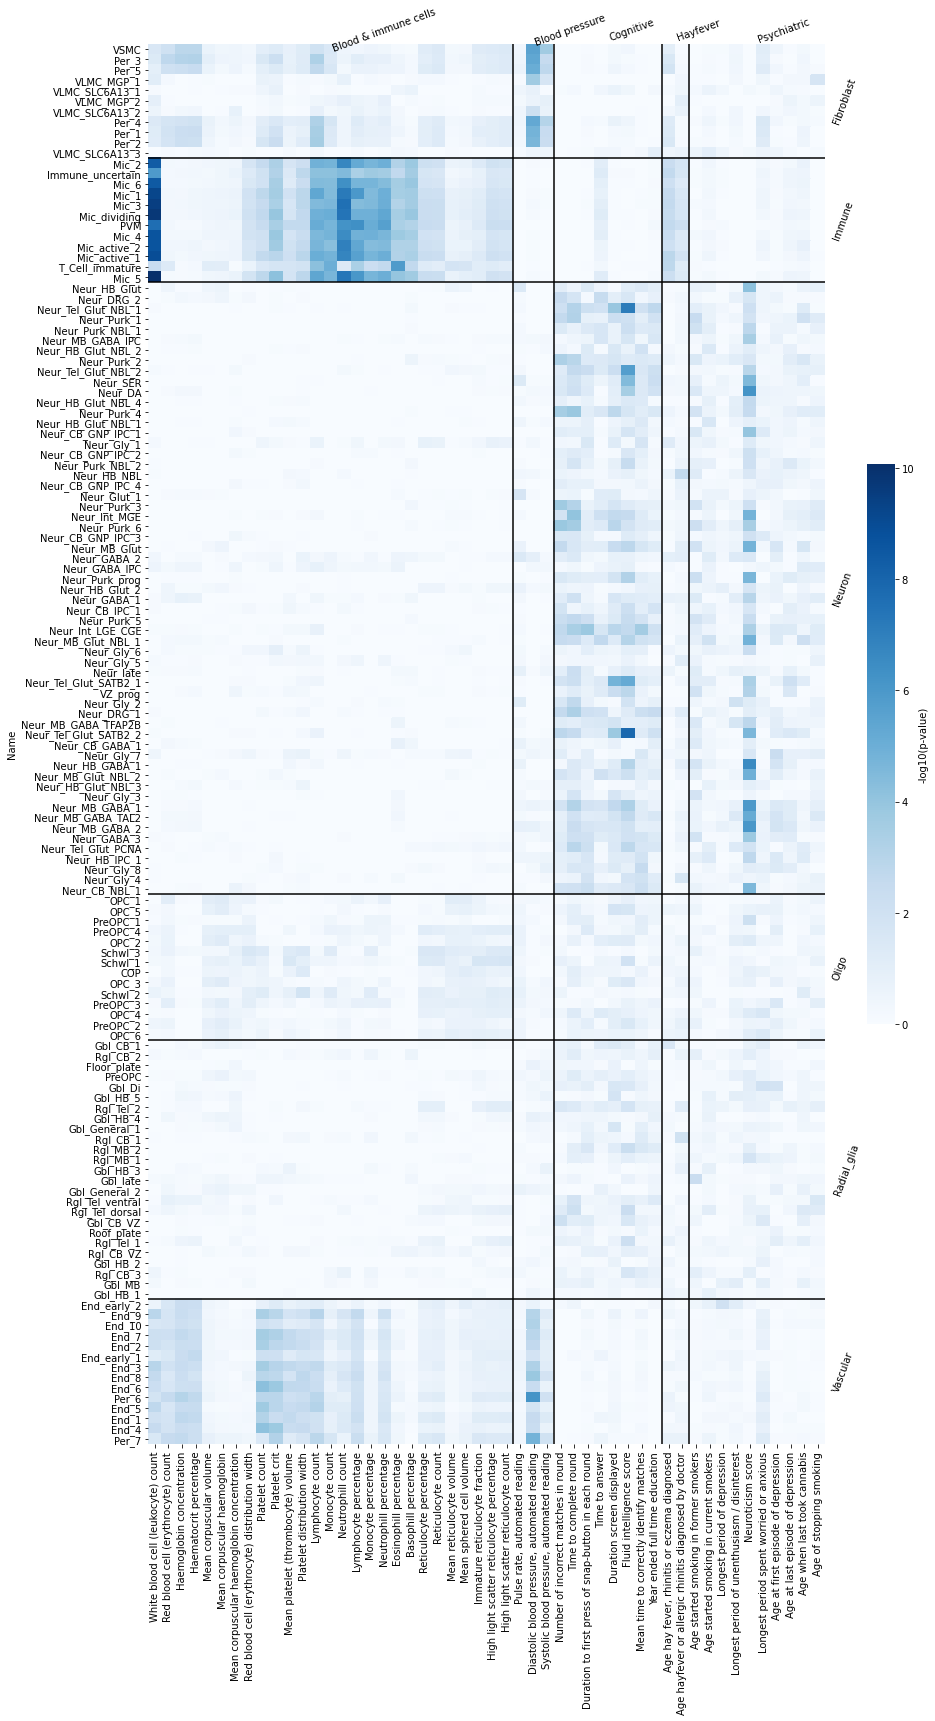

In [12]:
##### Preprocess data #####

df_ukb = parse_merged_ldsc_outputs(UKB_cont_merged, 'non_stringent')

#dict of cell type classes
class_dict =  {labels[i]: classes[i] for i in range(len(classes))}
class_name = []
for x in df_ukb['Name']:
    class_name.append(class_dict[x])
df_ukb['class'] = class_name


#phenotype to biological domain dict
domains = pd.read_csv(ukb_cont_manifest, sep='\t')
phenos = domains['phenotype']
domain = domains['Keep_category']
domain_dict = {phenos[i]: domain[i] for i in range(len(domain))}
domains = []
for x in df_ukb['Phenotype']:
    if '_' in str(x):
        y = x.split('_')[0]
    else:
        y = x
    y = str(y) + '_raw'
    domains.append(domain_dict[y])
df_ukb['domain'] = domains
df_ukb = df_ukb.dropna()

#transpose and sort
df_sorted = df_ukb.sort_values(['class'], ascending=[True], inplace=False)
df_transposed = df_sorted.pivot_table(index='Name', columns='Phenotype', values='log_P', sort=False)

#reorder new_df 
X = list(df_transposed.columns)
Y= []
new_x = []
xlabels = []
ylabels = []

for x in X:
    if '_' in str(x):
        x = x.split('_')[0]
    x = str(x) + '_raw'
    Y.append(domain_dict[x])
    
new_order, xlabels, ylabels, horizontal_demarkations, vertical_demarkations = reorder_ukb(df_transposed, class_dict, X,Y)
new_df = df_transposed[new_order]

#save continuous trait labels
ylabels_cont = ylabels

print(f"Total phenotypes: {len(np.unique(df_ukb['Phenotype']))}")

##### Plot log transformed data #####

## Manifests

continuous_manifest = pd.read_table(ukb_cont_manifest)
binary_manifest = pd.read_table(UKB_binary_manifest)

named_cols = []
for i in new_df.columns:
    x = continuous_manifest['phenotype']== str(i)+'_raw'
    
    named_cols.append(continuous_manifest[x]['description'].values[0])

new_df.columns = named_cols
    
#initiate plot
plt.figure(figsize=(14,24))
ax = sns.heatmap(new_df, cmap='Blues', xticklabels=True, yticklabels=True, 
                 cbar_kws={"shrink": 0.4,
                                                "label": '-log10(p-value)'})#, annot=True)

#set horizontal and vertical lines for domains and cell classes
ax.vlines(vertical_demarkations, color='black', *ax.get_ylim())
ax.hlines(horizontal_demarkations, color='black', *ax.get_xlim())

#set class labels
hdmarks = [0]
hdmarks.extend(horizontal_demarkations)
hdmarks.extend([new_df.shape[0]])
for i in range(len(xlabels)):
    ax.text(1.01, (hdmarks[i]+ hdmarks[i+1]) / 2, xlabels[i], ha='left', va='center', rotation = 70, size=10, fontdict=None, transform=ax.get_yaxis_transform())
    
#set domain labels
hdmarks = [0]
hdmarks.extend(vertical_demarkations)
hdmarks.extend([new_df.shape[1]])
for i in range(len(ylabels)):
    ax.text((hdmarks[i]+ hdmarks[i+1]) / 2, 1.01, ylabels[i], ha='left', va='center', rotation = 20, size=10, fontdict=None, transform=ax.get_xaxis_transform())

#show plot layout
plt.tight_layout()  #fit all text nicely into the plot

plt.savefig(os.path.join(export_folder, 'fig5_Continuous_associations.svg'), bbox_inches='tight')

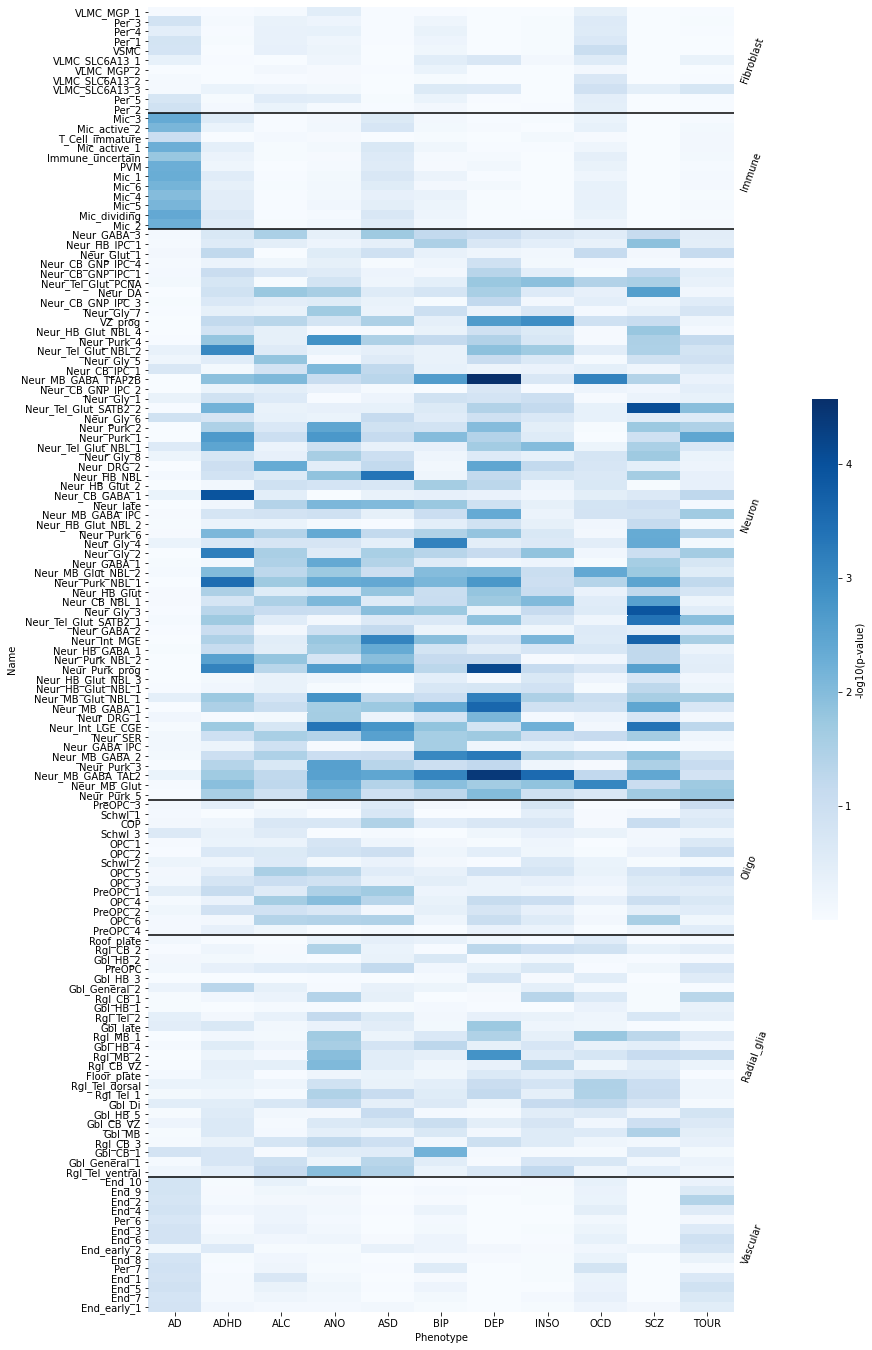

In [11]:
## Psychiatric Phenotypes
df_psy = parse_merged_ldsc_outputs(psy_merged, 'Stringent')
df_psy = df_psy.drop('index', axis = 1)
class_dict =  {labels[i]: classes[i] for i in range(len(classes))}
class_name = []
for x in df_psy['Name']:
    class_name.append(class_dict[x])
df_psy['class'] = class_name
df_psy_sorted = df_psy.sort_values(['class'], ascending=[True], inplace=False)
df_psy_sorted.reset_index(inplace=True, drop=True)

psy_transposed = df_psy_sorted.pivot_table(index='Name', columns='Phenotype', values='log_P', sort=False)

ylabels, horizontal_demarkations =  reorder_psy(psy_transposed, class_dict)

plt.figure(figsize=(14, 24))
ax = sns.heatmap(psy_transposed, cmap='Blues',  xticklabels=True, yticklabels=True, 
                                                         cbar_kws={"shrink": 0.4,
                                                         "label": '-log10(p-value)',
                                                         "pad": .1})#, annot=True)
ax.hlines(horizontal_demarkations, color='black', *ax.get_xlim())

xlabels = []
labelx = class_dict[psy_transposed.index[0]]
xlabels.append(labelx)
for i in range(len(psy_transposed.index)):
    cname = psy_transposed.index[i]
    if not labelx == class_dict[cname]:
        labelx = class_dict[cname]
        xlabels.append(labelx)

#set class labels
hdmarks = [0]
hdmarks.extend(horizontal_demarkations)
hdmarks.extend([psy_transposed.shape[0]])
for i in range(len(ylabels)):
    ax.text(1.01, (hdmarks[i]+ hdmarks[i+1]) / 2, xlabels[i], ha='left', va='center', rotation = 70, size=10, fontdict=None, transform=ax.get_yaxis_transform())
#plt.tight_layout()  #fit all text nicely into the plot
plt.xticks(fontsize=10)

plt.savefig(os.path.join(export_folder, 'fig5_GWAS_all_Psychiatric.svg'), bbox_inches='tight')

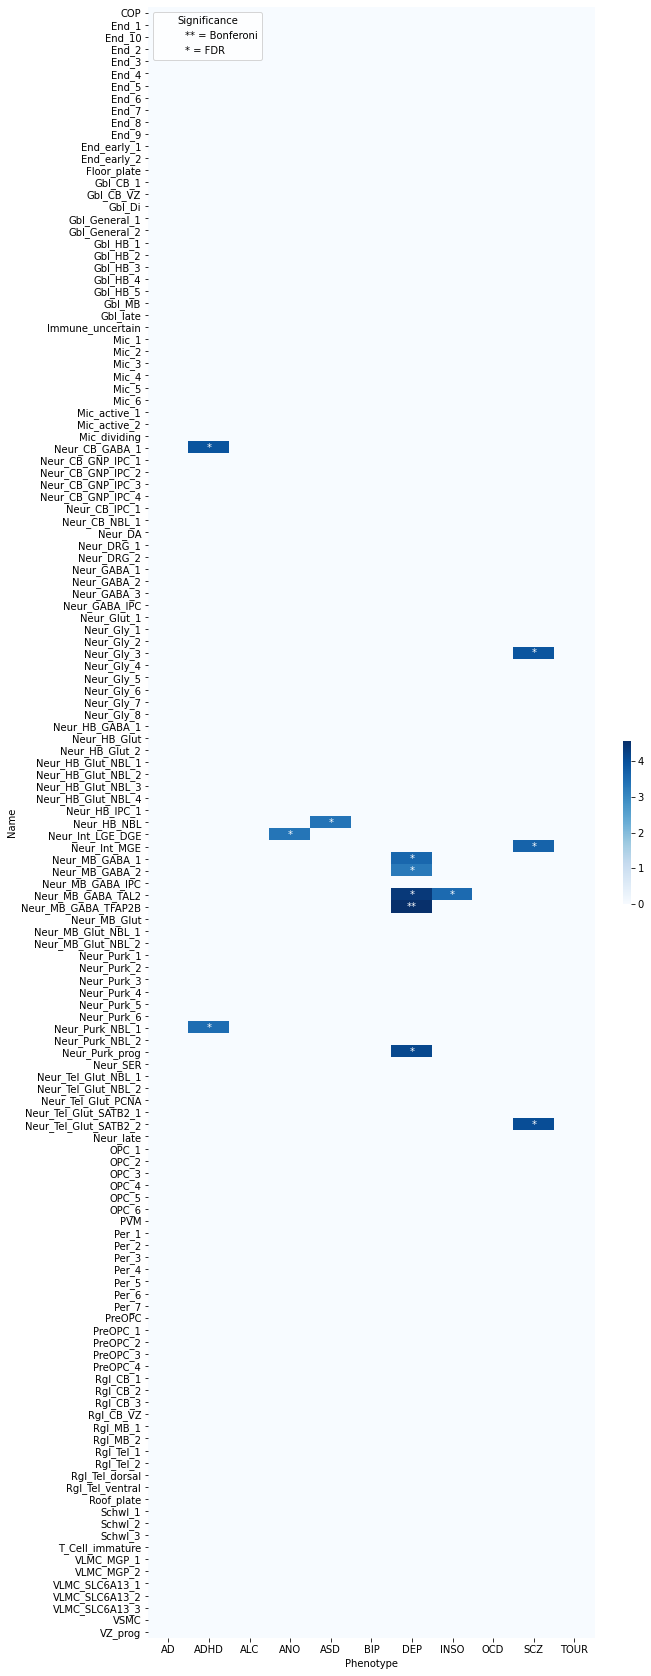

In [5]:
import matplotlib.patches as mpatches
new_df = df_psy.pivot_table(index='Name', columns='Phenotype', values='log_P')
bonf_df = df_psy.pivot_table(index='Name', columns='Phenotype', values='bonf')
ast_df = []
for ri in range(new_df.shape[0]):
    row = []
    for ci in range(new_df.shape[1]):
        bonf = bonf_df.iloc[ri,ci]
        if bonf == 1.0:
            row.append('**')
        elif bonf == 0.75:
            row.append('*')
        else:
            row.append('')
    ast_df.append(row)


for col in new_df.columns:
    new_df = new_df.where(bonf_df > 0.74, 0)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,30))
sns.heatmap(new_df, annot=ast_df, fmt='', cmap='Blues', cbar_kws={"shrink": 0.1})#, annot=True)
bonf_patch = mpatches.Patch(color='None', label='** = Bonferoni')
FDR_patch = mpatches.Patch(color='None', label='* = FDR')
plt.legend(loc="upper left", title='Significance', handles = [bonf_patch, FDR_patch])
plt.savefig(os.path.join(export_folder, 'fig5_GWAS_all_Psychiatric_significant.svg'), bbox_inches='tight')

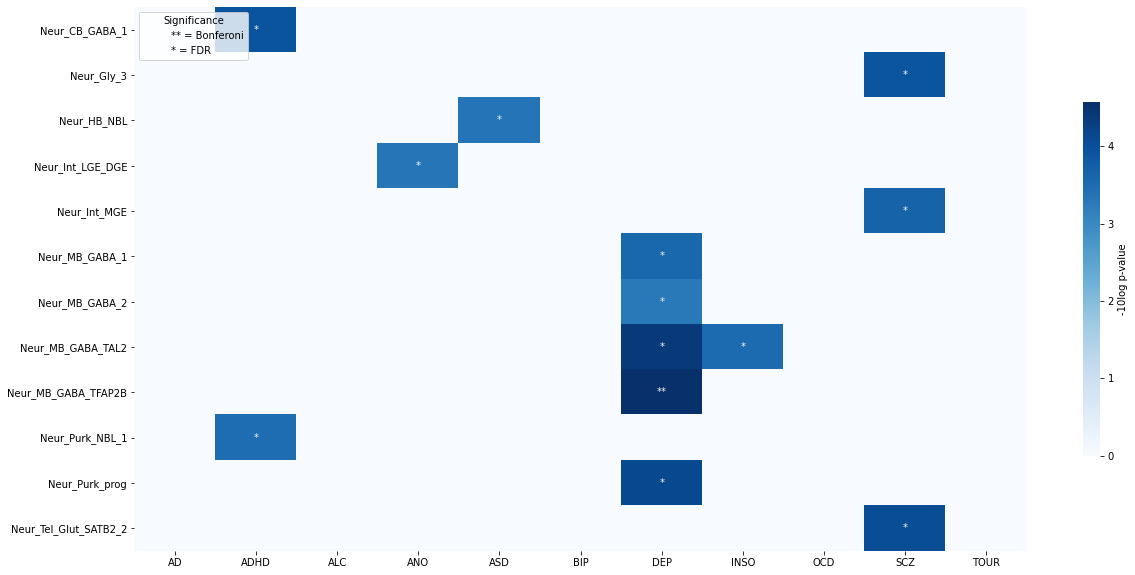

In [6]:
plt.figure(figsize=(20,10))

sig_df = pd.DataFrame()
for index,row in new_df.iterrows():
    if sum(row) > 0:
        sig_df = pd.concat([sig_df, row], axis =1 )
sig_ast = []
for element in ast_df:
    if '*' in element or '**' in element:
        sig_ast.append(element)

ax = sns.heatmap(sig_df.T, annot=sig_ast, fmt='', cmap='Blues', cbar_kws={"shrink": 0.65})#, annot=True)
bonf_patch = mpatches.Patch(color='None', label='** = Bonferoni')
FDR_patch = mpatches.Patch(color='None', label='* = FDR')
ax.collections[0].colorbar.set_label("-10log p-value")
plt.legend(loc="upper left", title='Significance', handles = [bonf_patch, FDR_patch])
plt.savefig(os.path.join(export_folder, 'fig5_GWAS_Psychiatric_significant.svg'), bbox_inches='tight')

/home/camiel/anaconda3/envs/chromo/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


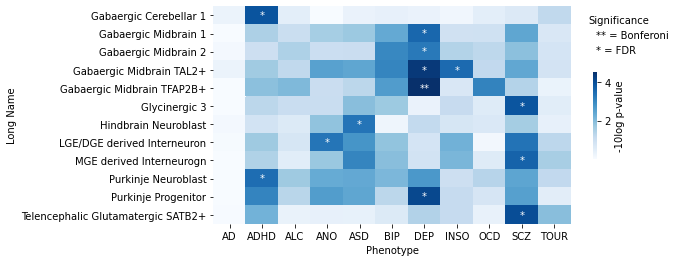

In [7]:
label = 'Long Name'

new_names = {'Neur_CB_GABA_1': 'Gabaergic Cerebellar 1', 
             'Neur_Gly_3': 'Glycinergic 3', 
             'Neur_HB_NBL': 'Hindbrain Neuroblast', 
             'Neur_Int_LGE_DGE': 'LGE/DGE derived Interneuron',
             'Neur_Int_MGE': 'MGE derived Interneurogn', 
             'Neur_MB_GABA_1': 'Gabaergic Midbrain 1', 
             'Neur_MB_GABA_2': 'Gabaergic Midbrain 2',
             'Neur_MB_GABA_TAL2': 'Gabaergic Midbrain TAL2+', 
             'Neur_MB_GABA_TFAP2B': 'Gabaergic Midbrain TFAP2B+', 
             'Neur_Purk_NBL_1': 'Purkinje Neuroblast',
             'Neur_Purk_prog': 'Purkinje Progenitor', 
             'Neur_Tel_Glut_SATB2_2': 'Telencephalic Glutamatergic SATB2+'}

ct = sig_df.columns
subset = df_psy_sorted[np.isin(df_psy_sorted['Name'], ct)]
subset['Long Name'] = np.array(new_names[i] for i in subset['Name'])
subset = subset.sort_values(by=label)
pivot = subset.pivot_table(index=label, columns='Phenotype', values='log_P')
bonf_df = subset.pivot_table(index=label, columns='Phenotype', values='bonf')

ast_df = []
for ri in range(pivot.shape[0]):
    row = []
    for ci in range(pivot.shape[1]):
        bonf = bonf_df.iloc[ri,ci]
        if bonf == 1.0:
            row.append('**')
        elif bonf == 0.75:
            row.append('*')
        else:
            row.append('')
    ast_df.append(row)
# ast_df = np.array(ast_df)
    
plt.figure(figsize=(8,4))
ax = sns.heatmap(pivot, cmap='Blues', annot=ast_df, fmt='', cbar_kws={"shrink": 0.4})#, annot=True)
bonf_patch = mpatches.Patch(color='None', label='** = Bonferoni')
FDR_patch = mpatches.Patch(color='None', label='* = FDR')
ax.collections[0].colorbar.set_label("-10log p-value")
plt.legend(bbox_to_anchor=(1.3,1), title='Significance', frameon=False, labelspacing = .5,
           handles = [bonf_patch, FDR_patch])

plt.savefig(os.path.join(export_folder, 'fig5_GWAS_Psychiatric_pvals.svg'), bbox_inches='tight')

## Plot Genes significantly associated with enriched cCREs

In [4]:
chrom_starts = {
    '1': 0,
    '2': 248956422,
    '3': 491149951,
    '4': 689445510,
    '5': 879660065,
    '6': 1061198324,
    '7': 1232004303,
    '8': 1391350276,
    '9': 1536488912,
    '10': 1674883629,
    '11': 1808681051,
    '12': 1943767673,
    '13': 2077042982,
    '14': 2191407310,
    '15': 2298451028,
    '16': 2400442217,
    '17': 2490780562,
    '18': 2574038003,
    '19': 2654411288,
    '20': 2713028904,
    '21': 2777473071,
    '22': 2824183054,
    'X': 2875001522,
    'Y': 3031042417
}

f = '../files/Figure_5/MAGMA_Gene_per_phenotype/DEP_remapped.magma_output'
data = []
with open(f, 'r') as file:
    for line in file:
        line = list(filter(None, line.split('\t')))
        line = [x.strip('\n') for x in line]
        data.append(line)

MAGMA = pd.DataFrame(np.array(data[1:])[:,1:], columns = data[0])
MAGMA['P'] = MAGMA['P'].astype(float)

MAGMA['FDR'] = multipletests(MAGMA['P'], method='fdr_bh')[1]
valid = MAGMA['FDR'] < .05
    
MAGMA = pd.DataFrame(np.array(data[1:])[:,1:], columns = data[0])
MAGMA['P'] = MAGMA['P'].astype(float)
MAGMA['BH'] = MAGMA['BH'].astype(float)
offset = np.array([chrom_starts[x] for x in MAGMA['CHR']])
MAGMA['pos'] = offset + MAGMA['START'].astype(int)

/home/camiel/anaconda3/envs/chromo/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  app.launch_new_instance()


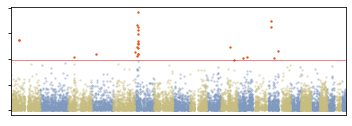

In [7]:
s = 20

significant = MAGMA['BH'] < .05
uneven = np.array(MAGMA['CHR'].astype(int) % 2).astype(bool)
alpha = np.mean((np.max(MAGMA['P'][significant]), np.min(MAGMA['P'][~significant])))

plt.figure(figsize=(6,2))
plt.scatter(MAGMA['pos'][~uneven], -np.log10(MAGMA['P'].astype(float))[~uneven], s=s, marker='.', lw=0, c='#8099bf',alpha=.5)
plt.scatter(MAGMA['pos'][uneven], -np.log10(MAGMA['P'].astype(float))[uneven], s=s, marker='.', lw=0, c='#c7bd80',alpha=.5)
plt.scatter(MAGMA['pos'][significant], -np.log10(MAGMA['P'].astype(float))[significant], s=s, marker='.', lw=0, c='#fe5005')
plt.axhline(-np.log10(alpha), lw=.5, c='red')
plt.xticks([]);
plt.xlim(0, np.max(MAGMA['pos'])+1)
plt.xlabel('Chromosome')
plt.yticks([0,2,4,6,8], labels=[0,2,4,6,8]);
plt.ylabel('-log10 p-value')

plt.savefig('/datb/sl/camiel/scATAC/DEV_manuscript/fig_5/fig5_Gene_Manhattan.png', dpi=1200, bbox_layout='tight')

## Plotting MAGMA results

In [3]:
## Used only to read results of the MAGMA analysis, HOMER motif enrichment analysis has been conducted on the FDR corrected regions here

f = '../files/Figure_5/MAGMA_cCRE_per_phenotype/MAGMA/DEP_magma_cCRE_locs.genes.out'
pheno = f.split('/')[-1].split('_')[0]

data = []
with open(f, 'r') as file:
    for line in file:
        line = list(filter(None, line.split(' ')))
        line = [x.strip('\n') for x in line]
        data.append(line)

MAGMA = pd.DataFrame(np.array(data[1:]), columns = data[0])
MAGMA['P'] = MAGMA['P'].astype(float)
MAGMA['FDR'] = multipletests(MAGMA['P'], method='fdr_bh')[1]
MAGMA = MAGMA.sort_values(by='P')
enh = MAGMA.loc[MAGMA['FDR'] < .05]

In [162]:
from bs4 import BeautifulSoup
f = '../files/Figure_5/MAGMA_cCRE_per_phenotype/homer/results/DEP_regions/homerResults.html'
soup = BeautifulSoup(open(f, 'rb'), 'html.parser')

strs = np.array([x.string for x in soup.find_all('td')])
mtch = np.array([x for x in soup.find_all('td')])

br = np.where(strs == '1\n')[0][0]
cols = strs[:br]
data = strs[br:]
data = data.reshape([int(len(data)/br), br])

selected = np.fromiter(range((2*br)-2,br*data.shape[0]+br,br),dtype=int)
TFs = [x.get_text().split('/')[0] for x in mtch[selected]]

for i in range(len(TFs)):
    if '_' in TFs[i]:
        TFs[i] = '_'.join(TFs[i].split('_')[1:])

df = pd.DataFrame(data, columns=cols)
df['Transciption Factor'] = np.array(TFs)
df['log P-pvalue'] = - df['log P-pvalue'].astype(float)
df['P-value'] = df['P-value'].astype(float)
df = df.sort_values(by='log P-pvalue', ascending=True)

/home/camiel/anaconda3/envs/chromo/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


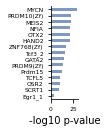

In [25]:
fig, ax = plt.subplots(1,1,figsize=(.5,1.7))
df.plot.barh(y = 'log P-pvalue', x = 'Transciption Factor',
             legend = None, ax = ax, color = '#8099bf', ylabel = None,
             fontsize=6)
for pos in ['right', 'top']:
    plt.gca().spines[pos].set_visible(False)
plt.ylabel(None);
plt.xlabel('-log10 p-value')
plt.savefig(os.path.join(export_folder, 'fig5_MDD_TF_enrichment.svg'), bbox_inches='tight')

## SNP overlap motifs

In [8]:
peaks = BedTool('../files/Figure_5/DEP_SNP_plotting/consensus_peaks.bed')
SNPs = BedTool('../files/Figure_5/DEP_SNP_plotting/sig_snps.bed')

valid_peaks = peaks.intersect(SNPs, wo=True)
enhancers = [x[3] for x in valid_peaks]

1it [00:00, 739.74it/s]


(-0.5, 400.5)

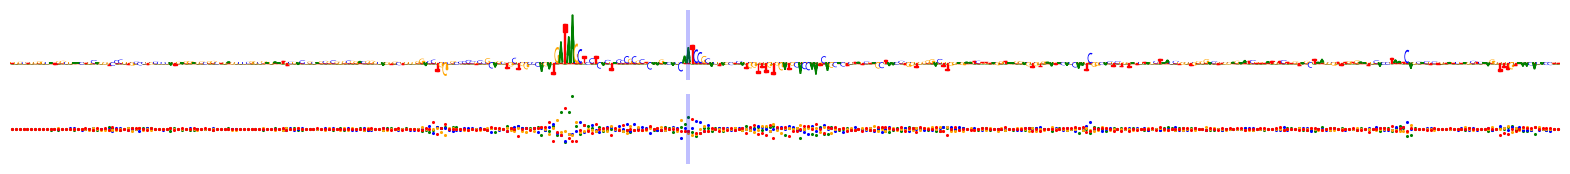

In [32]:
## Load the model
model = ConvolutionalClassificationModel(n_celltypes=5, length=401)
model.load_state_dict(state_dict = torch.load(f_model))
model.eval()
explainer = DeepLiftShap(model)

f_bit = '/datb/sl/camiel/scATAC/ref/hg38.2bit' ## The .2bit reference can be downloaded from here: https://hgdownload-test.gi.ucsc.edu/goldenPath/hg38/bigZips/hg38.2bit

hypo_contributions = []
contrib_scores= []

plot_cCRE = 'chr6:28885244-28885645'

onehot_data = one_hot_encoder([plot_cCRE], 401, f_bit)[0]
mult = explainer.attribute(torch.tensor(onehot_data[None, :, :]), shuffle_several_times(onehot_data), target=3).detach().numpy()[0]
bg_data = np.mean(shuffle_several_times(onehot_data).numpy(),axis=0)

hypo = combine_mult_and_diffref(mult, orig_inp=torch.tensor(onehot_data[None, :, :]), bg_data=bg_data)
hypo_contributions = hypo

dinuc_shuff_explanation = np.sum(mult, axis=0) * onehot_data
contrib_scores = dinuc_shuff_explanation

colors = ['Green', 'Blue', 'Orange', 'Red']

offset = SNP_pos - start

fig, ax = plt.subplots(2,1, figsize=(20,2))
viz_sequence.plot_weights_given_ax(ax[0], contrib_scores, .1, .1, highlight = [], subticks_frequency=400)
ax[0].axvspan(offset-1, offset, color='blue', alpha=0.25, lw=0)
ax[0].axis('off')

hypo = hypo_contributions.T
X = np.arange(hypo.shape[0])
for x in range(4):
    ax[1].scatter(X, hypo[:,x], c=colors[x], lw=0, s=5)
ax[1].axis('off')
ax[1].axvspan(offset-1.5, offset-.5, color='blue', alpha=0.25, lw=0)
mx = np.max(abs(hypo))
ax[1].set_ylim((-1.05*mx,1.05*mx))
ax[1].set_xlim(-.5,400.5)
        
# plt.savefig(os.path.join(export_folder, 'fig5_OTX2_chr6:28885244-28885645_rs114155007.svg'), bbox_inches='tight')